In [1]:
#dependencies
import pandas as pd
import seaborn as sns
import sqlite3
from sqlite3 import Error
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
#force output to display the full description
# pd.set_option('display.max_colwidth', -1)
#create connection to database
# conn = sqlite3.connect('db\wine_data.sqlite')
# c = conn.cursor()

In [2]:
#create the pandas data frame
wine_df = pd.read_csv('/Users/nico_marais/code/Liedjieboer/forward_farming_big_datasets/winemag-data-130k-v2.csv')
#display the top 3 records from the data frame
wine_df.head(3)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [3]:
#inline function to produce word count, splitting on spaces
wine_df['word_count'] = wine_df['description'].apply(lambda x: len(str(x).split(" ")))
wine_df.word_count.describe()

count    129971.000000
mean         40.384440
std          11.113601
min           3.000000
25%          33.000000
50%          39.000000
75%          47.000000
max         135.000000
Name: word_count, dtype: float64

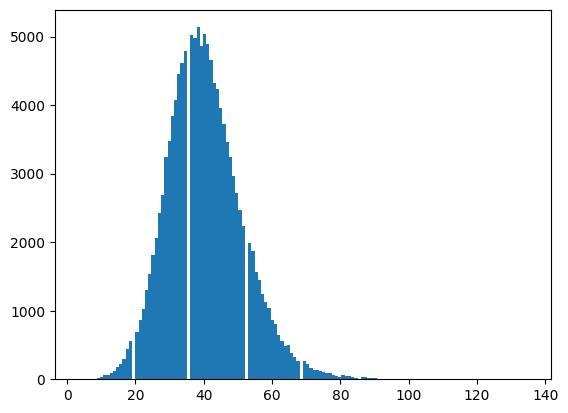

In [4]:
#set x for the histogram and set bins based on max
x = wine_df['word_count']
n_bins = 140
#plot histogram
plt.hist(x, bins=n_bins)
plt.show()

In [5]:
stop_words = set(stopwords.words("english"))
#show how many words are in the list of stop words
print(len(stop_words))
#179

179


In [6]:
#loops through descriptions and cleans them
clean_desc = []
for w in range(len(wine_df.description)):
    desc = wine_df['description'][w].lower()
    
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)
    
    #remove digits and special chars
    desc=re.sub("(\\d|\\W)+"," ",desc)
    
    clean_desc.append(desc)
#assign the cleaned descriptions to the data frame
wine_df['clean_desc'] = clean_desc

In [7]:
#calculate the frequency
word_frequency = pd.Series(' '.join(wine_df['clean_desc']).split()).value_counts()[:30]
word_frequency

and        347897
the        221367
a          180076
of         173050
with       120515
this       114193
is          96816
it          86101
wine        80360
flavors     62796
in          62522
to          56076
s           52995
fruit       49939
on          45664
that        40545
aromas      39639
palate      38523
acidity     35003
finish      34974
from        32609
but         31189
tannins     30878
drink       30323
cherry      29322
black       29024
ripe        27377
are         25876
has         24721
red         21784
dtype: int64

In [8]:
#add list of words to stoplist
add_stopwords = ["wine", "drink"]
stop_words = stop_words.union(add_stopwords)
print(len(stop_words))

181


In [9]:
stem_desc = []
for w in range(len(wine_df['clean_desc'])):
    split_text = wine_df['clean_desc'][w].split()

In [10]:
#Stemming
# stm = SnowballStemmer("english")
# split_text = [stm.stem(word) for word in split_text if not word in stop_words] 
# split_text = " ".join(split_text)
# stem_desc.append(split_text)

In [11]:
#Lemmatisation
lem = WordNetLemmatizer()
split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words] 
split_text = " ".join(split_text)
stem_desc.append(split_text)
stem_desc

['big rich dry powered intense spiciness rounded texture lychee dominate fruit profile giving opulent feel aftertaste']

In [12]:
#set the word cloud parameters
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color = 'black', 
                      stopwords = stop_words, 
                      max_words = 1000, 
                      min_font_size = 20).generate(str(stem_desc))

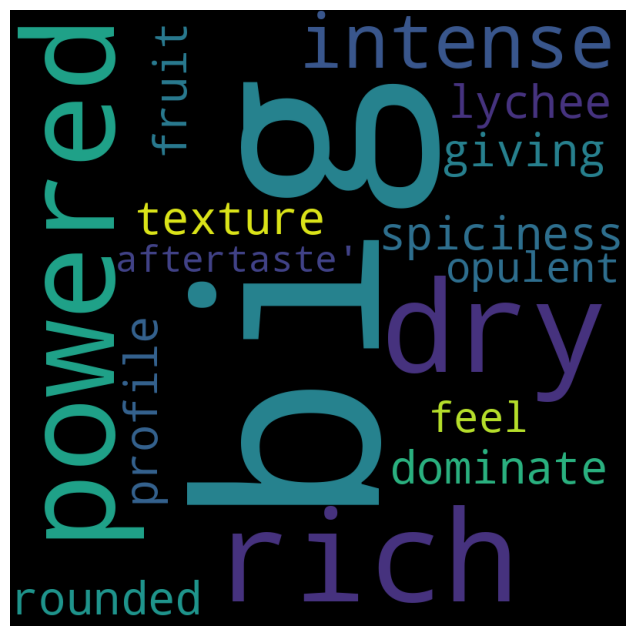

In [13]:
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("wordcloud.png")

In [14]:
def get_trigrams(descriptions, n=None):
    
    vec = CountVectorizer(ngram_range = (3,3), max_features = 20000).fit(descriptions)
    bag_of_words = vec.transform(descriptions)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

In [15]:
stops = ['wine','the', 'drink', 'an', 'cabernet', 'sauvignon', 'black', 'cherry']
stem_desc = []
for w in range(len(wine_df['clean_desc'])):
    split_text = wine_df['clean_desc'][w].split()
       
    #Lemmatisation
lem = WordNetLemmatizer()
split_text = [lem.lemmatize(word) for word in split_text if not word in stops] 
split_text = " ".join(split_text)
stem_desc.append(split_text)
trigrams = get_trigrams(clean_desc, n=15)


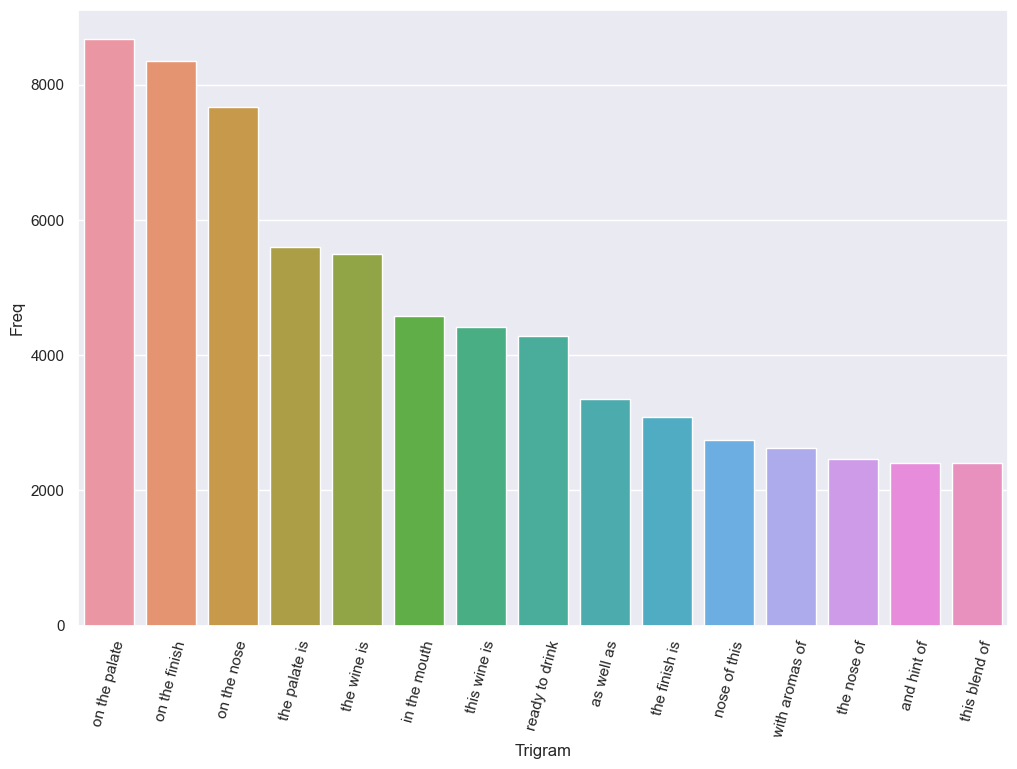

In [16]:
#create a trigram data frame
trigram_df = pd.DataFrame(trigrams)
trigram_df.columns=["Trigram", "Freq"]
#output top 15 rows
trigram_df.head(15)
fig = sns.set(rc = {'figure.figsize':(12,8)})
bp = sns.barplot(x = "Trigram", y = "Freq", data = trigram_df)
bp.set_xticklabels(bp.get_xticklabels(), rotation = 75)
plt.show()

In [18]:
trigram_df

,Trigram,Freq
0,on the palate,8673
1,on the finish,8347
2,on the nose,7663
3,the palate is,5597
4,the wine is,5498
5,in the mouth,4574
6,this wine is,4417
7,ready to drink,4283
8,as well as,3357
9,the finish is,3092
